# Transfer Learning

Transfer Learning leverages a pretrained model that is already extremely performant on general feature detection. Our work will be to re-train this model on our specific dataset and add the specialized knowledge needed to solve our task.

Since the model is already pre-trained we can expect that we will only need about `10%` of the amount of data that would be needed to train a fresh model.

## Feature Extraction

Download a pre-trained model and set it's layers as un-trainable. The model is able to extract general features. All we need to do is adding a trainable dense layer (or a couple) at the end that we train to recognize our features among the features returned from the base model.

* cd datasets
* wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
* unzip 10_food_classes_10_percent.zip && rm 10_food_classes_10_percent.zip

```
tree -L 2
10_food_classes_10_percent
├── test
│   ├── chicken_curry
│   ├── chicken_wings
│   ├── fried_rice
│   ├── grilled_salmon
│   ├── hamburger
│   ├── ice_cream
│   ├── pizza
│   ├── ramen
│   ├── steak
│   └── sushi
└── train
    ├── chicken_curry
    ├── chicken_wings
    ├── fried_rice
    ├── grilled_salmon
    ├── hamburger
    ├── ice_cream
    ├── pizza
    ├── ramen
    ├── steak
    └── sushi
```

### Visualizing the Data

In [6]:
import datetime
import itertools
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
# check if you have GPU support
tf.config.list_physical_devices('GPU')
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# physical_devices = tf.config.list_physical_devices('GPU')
# for device in physical_devices:
#   tf.config.experimental.set_memory_growth(device, True)

2023-03-11 12:48:58.580060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 12:48:58.854256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 12:48:58.855051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# set directories
training_directory = "../datasets/10_food_classes_10_percent/train/"
testing_directory = "../datasets/10_food_classes_10_percent/test/"

# get class names
data_dir = pathlib.Path(training_directory)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
len(class_names), class_names 

# the data set has 10 classes:
# (10,
#  array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
#         'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
#        dtype='<U14'))

(10,
 array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
        'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
       dtype='<U14'))

2023-03-11 12:49:09.053350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-11 12:49:09.056244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 12:49:09.056407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-11 12:49:09.056530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUM

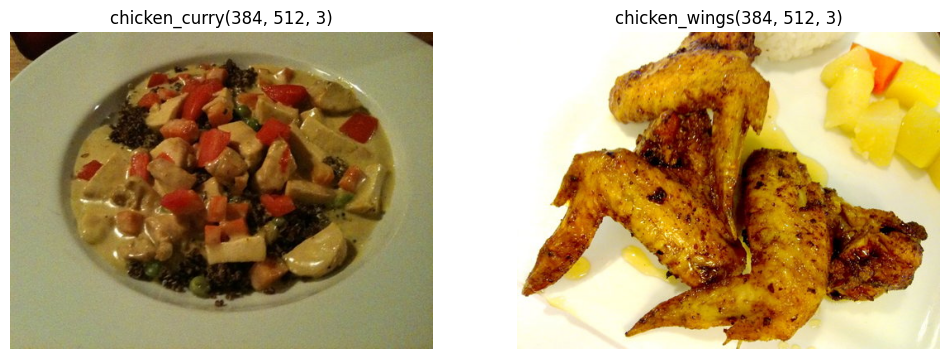

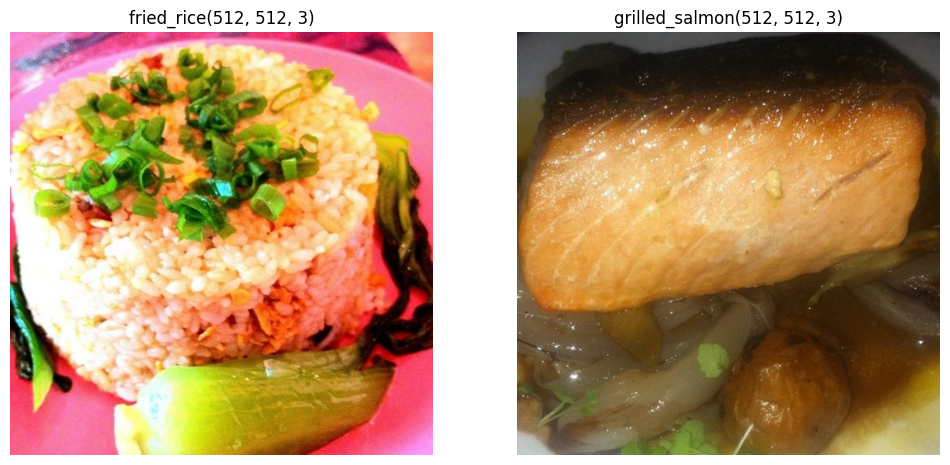

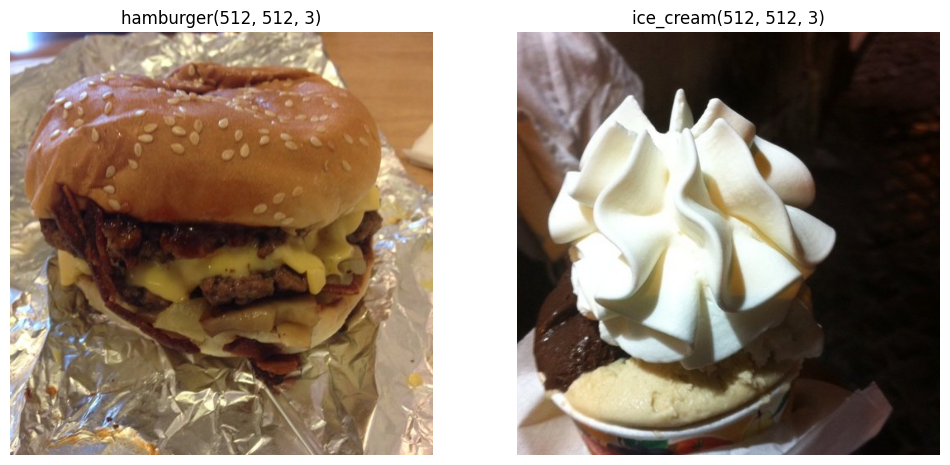

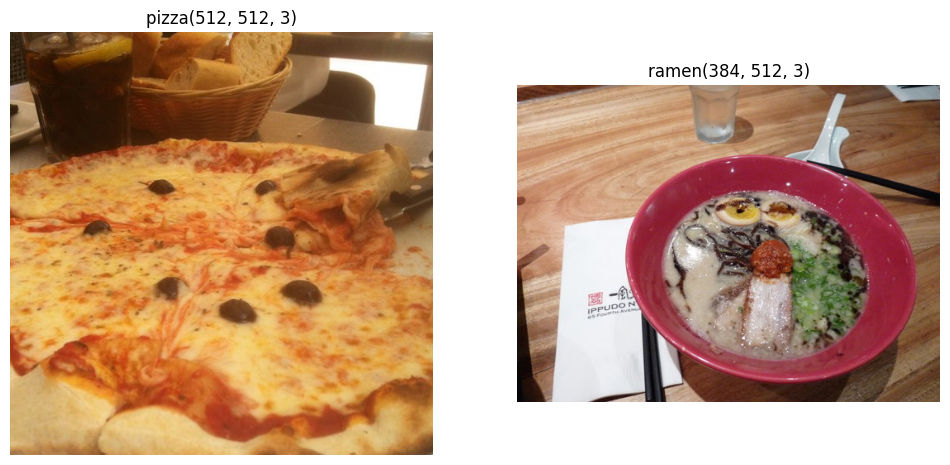

In [4]:
# visualizing the dataset
## display random images
def view_random_image(target_dir, target_class):
    target_folder = str(target_dir) + "/" + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(str(target_class) + str(img.shape))
    plt.axis("off")
    
    return tf.constant(img)

fig = plt.figure(figsize=(12, 6))
plot1 = fig.add_subplot(1, 2, 1)
plot1.title.set_text(f'Class: {class_names[0]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[0])
plot2 = fig.add_subplot(1, 2, 2)
plot2.title.set_text(f'Class: {class_names[1]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[1])

fig = plt.figure(figsize=(12, 6))
plot3 = fig.add_subplot(1, 2, 1)
plot3.title.set_text(f'Class: {class_names[2]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[2])
plot4 = fig.add_subplot(1, 2, 2)
plot4.title.set_text(f'Class: {class_names[3]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[3])

fig = plt.figure(figsize=(12, 6))
plot5 = fig.add_subplot(1, 2, 1)
plot5.title.set_text(f'Class: {class_names[4]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[4])
plot6 = fig.add_subplot(1, 2, 2)
plot6.title.set_text(f'Class: {class_names[5]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[5])

fig = plt.figure(figsize=(12, 6))
plot7 = fig.add_subplot(1, 2, 1)
plot7.title.set_text(f'Class: {class_names[6]}')
pizza_image = view_random_image(target_dir = training_directory, target_class=class_names[6])
plot8 = fig.add_subplot(1, 2, 2)
plot8.title.set_text(f'Class: {class_names[7]}')
steak_image = view_random_image(target_dir = training_directory, target_class=class_names[7])

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_01.png)

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_02.png)

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_03.png)

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_04.png)

### Preprocessing the Data

In [5]:
SEED = 42
BATCH_SIZE = 16
IMG_SHAPE = (224, 224)

training_data = image_dataset_from_directory(training_directory,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)

testing_data = image_dataset_from_directory(testing_directory,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)


# this time we only work with 10% of the training dataset
# Found 750 files belonging to 10 classes.
# Found 2500 files belonging to 10 classes.

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### TensorBoard Perfomance Tracking

In [6]:
# create a callback to track experiments in TensorBoard
def create_tensorboard_callback(dir_name, experiment_name):
    # log progress to log directory
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    print(f"Saving TensorBoard Log to: {log_dir}")
    return tensorboard_callback

### Building a Model from Tensorflow Hub

Pick a well performing model from the [Image Classification Leaderboard](https://paperswithcode.com/task/image-classification) and try to find it on:

* [Tensorflow Hub](https://tfhub.dev/s?module-type=image-classification,image-feature-vector&network-architecture=efficientnet-b0,resnet-v2-50&tf-version=tf2)
  * [EfficientNetB0 (feature-vector)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)
  * [ResNetv250 (feature_vector)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5)

In [7]:
# model comparison
resnet_model_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_model_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [8]:
# add image augmentations (optional)
# was needed before - but the pre-trained model
# usually does not need huge/augmented datasets
data_augmentation_layer = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])

# helper function to create a model
def create_model(model_url, num_classes):
    # download pre-trained model as a keras layer
    feature_extractor_layer = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name='feature_extractor_layer')
    
    # create sequential model
    model = tf.keras.Sequential([
        Rescaling(1./255, input_shape=IMG_SHAPE+(3,)),
        # data_augmentation_layer,
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])

    return model

### Creating a ResNet-based Model

In [9]:
resnet_model = create_model(resnet_model_url, len(class_names))

resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(learning_rate=1e-3),
                     metrics=["accuracy"])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [10]:
resnet_model.summary()

# Model: "sequential_1"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  rescaling (Rescaling)       (None, 224, 224, 3)       0         
#  feature_extractor_layer (Ke (None, 2048)             23564800  
#  rasLayer)
#  output_layer (Dense)        (None, 10)                20490
# =================================================================
# Total params: 23,585,290
# Trainable params: 20,490
# Non-trainable params: 23,564,800
# _________________________________________________________________

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


### Training the ResNet Model

In [11]:
tf.random.set_seed(SEED)
# fitting the model
history_resnet_model = resnet_model.fit(training_data, epochs=5,
                            steps_per_epoch=len(training_data),
                            validation_data=testing_data,
                            validation_steps=len(testing_data))

# Epoch 5/5
# 15s 325ms/step - loss: 0.2652 - accuracy: 0.9560 - val_loss: 0.6500 - val_accuracy: 0.7836

Epoch 1/5


2023-03-11 12:50:54.042154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-11 12:50:57.369982: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd610016040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-11 12:50:57.370101: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-03-11 12:50:57.422067: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-11 12:50:57.434280: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


 2/47 [>.............................] - ETA: 2s - loss: 3.0816 - accuracy: 0.0938      

2023-03-11 12:50:57.767698: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 [==============================] - 49s 852ms/step - loss: 1.6767 - accuracy: 0.4533 - val_loss: 0.9634 - val_accuracy: 0.7000
Epoch 2/5
47/47 [==============================] - 15s 319ms/step - loss: 0.7109 - accuracy: 0.7760 - val_loss: 0.7513 - val_accuracy: 0.7676
Epoch 3/5
47/47 [==============================] - 15s 320ms/step - loss: 0.4862 - accuracy: 0.8627 - val_loss: 0.7023 - val_accuracy: 0.7712
Epoch 4/5
47/47 [==============================] - 15s 320ms/step - loss: 0.3490 - accuracy: 0.9253 - val_loss: 0.6620 - val_accuracy: 0.7828
Epoch 5/5
47/47 [==============================] - 15s 325ms/step - loss: 0.2652 - accuracy: 0.9560 - val_loss: 0.6500 - val_accuracy: 0.7836


### Creating a EfficientNet-based Model

In [12]:
efficientnet_model = create_model(efficientnet_model_url, len(class_names))

efficientnet_model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

In [13]:
efficientnet_model.summary()

# Model: "sequential_2"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
#  feature_extractor_layer (Ke (None, 1280)             4049564   
#  rasLayer)                                                       
#  output_layer (Dense)        (None, 10)                12810     
# =================================================================
# Total params: 4,062,374
# Trainable params: 12,810
# Non-trainable params: 4,049,564
# _________________________________________________________________

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


### Training the EfficientNet Model

In [14]:
tf.random.set_seed(SEED)
# fitting the model
history_efficientnet_model = efficientnet_model.fit(training_data, epochs=15,
                            steps_per_epoch=len(training_data),
                            validation_data=testing_data,
                            validation_steps=len(testing_data))

# Epoch 15/15
# 11s 228ms/step - loss: 0.1133 - accuracy: 0.9920 - val_loss: 0.3779 - val_accuracy: 0.8828

Epoch 1/15
47/47 [==============================] - 20s 279ms/step - loss: 1.5641 - accuracy: 0.5627 - val_loss: 0.9654 - val_accuracy: 0.7956
Epoch 2/15
47/47 [==============================] - 11s 227ms/step - loss: 0.8051 - accuracy: 0.8213 - val_loss: 0.6785 - val_accuracy: 0.8460
Epoch 3/15
47/47 [==============================] - 11s 228ms/step - loss: 0.5879 - accuracy: 0.8653 - val_loss: 0.5728 - val_accuracy: 0.8620
Epoch 4/15
47/47 [==============================] - 10s 223ms/step - loss: 0.4677 - accuracy: 0.9000 - val_loss: 0.5167 - val_accuracy: 0.8652
Epoch 5/15
47/47 [==============================] - 11s 233ms/step - loss: 0.3863 - accuracy: 0.9240 - val_loss: 0.4776 - val_accuracy: 0.8732
Epoch 6/15
47/47 [==============================] - 11s 233ms/step - loss: 0.3305 - accuracy: 0.9387 - val_loss: 0.4549 - val_accuracy: 0.8736
Epoch 7/15
47/47 [==============================] - 11s 234ms/step - loss: 0.2836 - accuracy: 0.9547 - val_loss: 0.4357 - val_accuracy: 0.8800

### Comparing both Models

<AxesSubplot: title={'center': 'EfficientNet Model (Multiclass)'}>

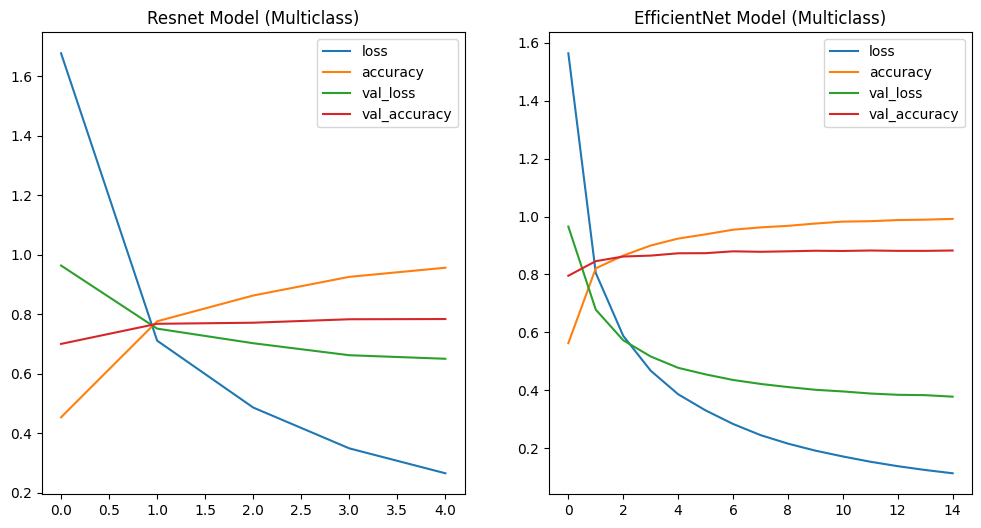

In [15]:
# plotting the loss curves
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.DataFrame(history_resnet_model.history).plot(ax=axes[0], title="Resnet Model (Multiclass)")
pd.DataFrame(history_efficientnet_model.history).plot(ax=axes[1], title="EfficientNet Model (Multiclass)")

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_05.png)

In [16]:
# Plot the validation and training accuracy separately
def plot_accuracy_curves(history1, title1, history2, title2):
  accuracy1 = history1.history['accuracy']
  val_accuracy1 = history1.history['val_accuracy']
  epochs1 = range(len(history1.history['accuracy']))

  accuracy2 = history2.history['accuracy']
  val_accuracy2 = history2.history['val_accuracy']
  epochs2 = range(len(history2.history['accuracy']))

  # Plot accuracy
  plt.figure(figsize=(12, 12))
    
  plt.subplot(2, 2, 1)
  plt.plot(epochs1, accuracy1, label='training_accuracy')
  plt.plot(epochs1, val_accuracy1, label='val_accuracy')
  plt.title(title1)
  plt.xlabel('Epochs')
  plt.legend();

  plt.subplot(2, 2, 2)
  plt.plot(epochs2, accuracy2, label='training_accuracy')
  plt.plot(epochs2, val_accuracy2, label='val_accuracy')
  plt.title(title2)
  plt.xlabel('Epochs')
  plt.legend();

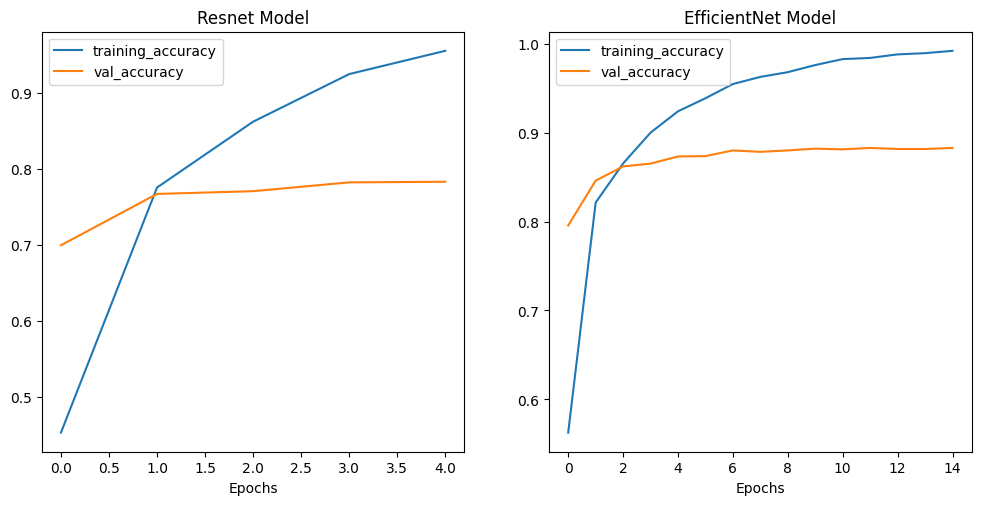

In [17]:
# plotting the accuracy curves
plot_accuracy_curves(history1=history_resnet_model,
                     title1="Resnet Model",
                     history2=history_efficientnet_model,
                     title2="EfficientNet Model")

![Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_06.png)


The accuracy of the EfficientNet model is even slightly better than the accuracy of the ResNet Model. There are several EfficientNet models to pick from:


![Transfer Learning](../assets/04_Efficientnet_vs_Resnet.png)


_Image source :: [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)_


The higher the amount of parameters become the less ressource efficient a training tends to become. The Optimum seems to be around the `B4` model.

### Using the Tensorboard Callback

#### ResNetV2 50 vs EfficientNetB0 vs EfficientNetB4

Let's compare the trained `B0` model with the `B4` (and `ResNetv2 50`):

##### EfficientNetB0

In [20]:
# building and training the __EfficientNet B0__ model
efficientnet0_model_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

efficientnet0_model = create_model(efficientnet0_model_url, len(class_names))

efficientnet0_model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

tf.random.set_seed(SEED)
# fitting the model
history_efficientnet0_model = efficientnet0_model.fit(training_data, epochs=15,
        callbacks=create_tensorboard_callback(dir_name='../tensorboard/efficientnet',
        experiment_name='resnet_b0'),
        steps_per_epoch=len(training_data),
        validation_data=testing_data,
        validation_steps=len(testing_data))

# Epoch 15/15
# 13s 284ms/step - loss: 0.1126 - accuracy: 0.9920 - val_loss: 0.3746 - val_accuracy: 0.8836

Saving TensorBoard Log to: ../tensorboard/efficientnet/resnet_b0/20230311-161912
Epoch 1/15
47/47 [==============================] - 24s 332ms/step - loss: 1.5914 - accuracy: 0.5480 - val_loss: 0.9693 - val_accuracy: 0.8088
Epoch 2/15
47/47 [==============================] - 13s 289ms/step - loss: 0.7938 - accuracy: 0.8213 - val_loss: 0.6710 - val_accuracy: 0.8552
Epoch 3/15
47/47 [==============================] - 13s 286ms/step - loss: 0.5762 - accuracy: 0.8733 - val_loss: 0.5632 - val_accuracy: 0.8620
Epoch 4/15
47/47 [==============================] - 13s 284ms/step - loss: 0.4602 - accuracy: 0.9040 - val_loss: 0.5045 - val_accuracy: 0.8732
Epoch 5/15
47/47 [==============================] - 14s 291ms/step - loss: 0.3802 - accuracy: 0.9267 - val_loss: 0.4712 - val_accuracy: 0.8744
Epoch 6/15
47/47 [==============================] - 13s 285ms/step - loss: 0.3293 - accuracy: 0.9347 - val_loss: 0.4532 - val_accuracy: 0.8760
Epoch 7/15
47/47 [==============================] - 14s 292ms

##### EfficientNetB4

In [21]:
# building and training the __EfficientNet B4__ model
efficientnet4_model_url = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'

efficientnet4_model = create_model(efficientnet4_model_url, len(class_names))

efficientnet4_model.compile(loss='categorical_crossentropy',
                    optimizer=Adam(learning_rate=1e-3),
                    metrics=['accuracy'])

tf.random.set_seed(SEED)
# fitting the model
history_efficientnet4_model = efficientnet4_model.fit(training_data, epochs=15,
        callbacks=create_tensorboard_callback(dir_name='../tensorboard/efficientnet',
        experiment_name='resnet_b4'),
        steps_per_epoch=len(training_data),
        validation_data=testing_data,
        validation_steps=len(testing_data))

# Epoch 15/15
# 33s 711ms/step - loss: 0.1176 - accuracy: 0.9893 - val_loss: 0.4109 - val_accuracy: 0.8648

Saving TensorBoard Log to: ../tensorboard/efficientnet/resnet_b4/20230311-162614
Epoch 1/15
47/47 [==============================] - 49s 726ms/step - loss: 1.5068 - accuracy: 0.5773 - val_loss: 0.8919 - val_accuracy: 0.7740
Epoch 2/15
47/47 [==============================] - 30s 653ms/step - loss: 0.7670 - accuracy: 0.8040 - val_loss: 0.6310 - val_accuracy: 0.8364
Epoch 3/15
47/47 [==============================] - 30s 657ms/step - loss: 0.5730 - accuracy: 0.8493 - val_loss: 0.5481 - val_accuracy: 0.8512
Epoch 4/15
47/47 [==============================] - 31s 667ms/step - loss: 0.4651 - accuracy: 0.8787 - val_loss: 0.5034 - val_accuracy: 0.8624
Epoch 5/15
47/47 [==============================] - 32s 693ms/step - loss: 0.3927 - accuracy: 0.9013 - val_loss: 0.4778 - val_accuracy: 0.8588
Epoch 6/15
47/47 [==============================] - 33s 714ms/step - loss: 0.3355 - accuracy: 0.9253 - val_loss: 0.4589 - val_accuracy: 0.8632
Epoch 7/15
47/47 [==============================] - 33s 703ms

##### ResNetv2 50

In [22]:
# building and training the __ResNetv2 50__ model
resnet2_50_model_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'

resnet2_50_model = create_model(resnet2_50_model_url, len(class_names))

resnet2_50_model.compile(loss="categorical_crossentropy",
                     optimizer=Adam(learning_rate=1e-3),
                     metrics=["accuracy"])

tf.random.set_seed(SEED)
# re-running the resnet training
history_resnet_model = resnet_model.fit(training_data, epochs=15,
        callbacks=create_tensorboard_callback(dir_name='../tensorboard/resnet',
        experiment_name='resnet_v2_50'),
        steps_per_epoch=len(training_data),
        validation_data=testing_data,
        validation_steps=len(testing_data))

# Epoch 15/15
# 19s 405ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.6888 - val_accuracy: 0.8028

Saving TensorBoard Log to: ../tensorboard/resnet/resnet_v2_50/20230311-163525
Epoch 1/15
47/47 [==============================] - 20s 410ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.6615 - val_accuracy: 0.8056
Epoch 2/15
47/47 [==============================] - 19s 413ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.6644 - val_accuracy: 0.8024
Epoch 3/15
47/47 [==============================] - 18s 391ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.6663 - val_accuracy: 0.8008
Epoch 4/15
47/47 [==============================] - 19s 400ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 0.6678 - val_accuracy: 0.8032
Epoch 5/15
47/47 [==============================] - 19s 403ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.6699 - val_accuracy: 0.8020
Epoch 6/15
47/47 [==============================] - 19s 399ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.6711 - val_accuracy: 0.8040
Epoch 7/15
47/47 [==============================] - 19s 416ms/st

In [23]:
efficientnet0_model.summary()

# Model: "sequential_3"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  rescaling_2 (Rescaling)     (None, 224, 224, 3)       0
#  feature_extractor_layer (Ke  (None, 1280)             4049564   
#  rasLayer)
#  output_layer (Dense)        (None, 10)                12810
# =================================================================
# Total params: 4,062,374
# Trainable params: 12,810
# Non-trainable params: 4,049,564
# _________________________________________________________________

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 1280)             4049564   
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [24]:
efficientnet4_model.summary()

# Model: "sequential_4"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  rescaling_3 (Rescaling)     (None, 224, 224, 3)       0
#  feature_extractor_layer (Ke  (None, 1792)             17673816  
#  rasLayer)
#  output_layer (Dense)        (None, 10)                17930     
# =================================================================
# Total params: 17,691,746
# Trainable params: 17,930
# Non-trainable params: 17,673,816
# _________________________________________________________________

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 1792)             17673816  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                17930     
                                                                 
Total params: 17,691,746
Trainable params: 17,930
Non-trainable params: 17,673,816
_________________________________________________________________


In [26]:
resnet2_50_model.summary()

# Model: "sequential_5"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  rescaling_4 (Rescaling)     (None, 224, 224, 3)       0
#  feature_extractor_layer (Ke  (None, 2048)             23564800  
#  rasLayer)
#  output_layer (Dense)        (None, 10)                20490    
# =================================================================
# Total params: 23,585,290
# Trainable params: 20,490
# Non-trainable params: 23,564,800
# _________________________________________________________________

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 feature_extractor_layer (Ke  (None, 2048)             23564800  
 rasLayer)                                                       
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


##### Summary

* EfficientNetB0
  * Trainable params: _12,810_
  * Non-trainable params: _4,049,564_
  * Training time per epoch: __13s__
  * Results (15 epochs): val_loss: _0.3746_ - val_accuracy: __0.8836__
* EfficientNetB4
  * Trainable params: _17,930_
  * Non-trainable params: _17,673,816_
  * Training time per epoch: __33s__
  * Results (15 epochs): val_loss: _0.4109_ - val_accuracy: __0.8648__
* ResNet50 v2
  * Trainable params: _20,490_
  * Non-trainable params: _23,564,800_
  * Training time per epoch: __19s__
  * Results (15 epochs): val_loss: _0.6888_ - val_accuracy: __0.8028__

In [28]:
# Load TensorBoard
%load_ext tensorboard
%tensorboard --logdir '../tensorboard/'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


![Transfer Learning](../assets/04_Efficientnet_vs_Resnet_Tensorboard.png)